In [3]:
from keras.utils import to_categorical

# We have 10 users, each is uniquely identified by an ID.
users = [i for i in range(10)]
to_categorical(users)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [4]:
import numpy as np

latent_dim = 5
inputs = to_categorical(users)
embed_mat = np.random.randn(len(users), latent_dim)

inputs.dot(embed_mat)

array([[-0.2619578 , -0.07973336, -0.66025135, -1.04832593,  1.56753105],
       [ 0.2131254 ,  1.6209721 ,  1.23505299,  0.29359519,  0.04763557],
       [ 1.88820197, -0.23566807,  0.45154454, -0.22897549, -0.72474719],
       [ 0.4798905 ,  1.86069052,  0.4029009 ,  0.13261708, -0.71171478],
       [ 0.61008105, -1.14323426, -0.02464377, -0.59138132, -1.78509225],
       [ 0.08581713,  1.21872759, -1.00918501,  0.15283907, -0.69060173],
       [-1.30445633, -0.79851979,  0.36555076,  0.10055544,  0.43487895],
       [ 0.02099263,  1.42705713,  0.20526165,  0.09427764,  0.14065221],
       [ 0.07161814,  0.46242875, -0.37459189,  0.84336128,  0.24884537],
       [ 0.25435569,  0.07809013,  1.60658344,  0.7620146 ,  0.27873086]])

In [5]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

dataset = pd.read_csv('/kaggle/input/rating-csv/rating.csv', header=0, names=['user_id', 'movie_id', 'rating', 'timestamp'])

# Need to map movie ID to [1, num_movies]
movie_id_to_new_id = dict()
id = 1
for index, row in dataset.iterrows():
    if movie_id_to_new_id.get(row['movie_id']) is None:
        movie_id_to_new_id[row['movie_id']] = id
        dataset.at[index, 'movie_id'] = id
        id += 1
    else:
        dataset.at[index, 'movie_id'] = movie_id_to_new_id.get(row['movie_id'])

num_users = len(dataset.user_id.unique())
num_movies = len(dataset.movie_id.unique())
train, test = train_test_split(dataset, test_size=0.2)

print('Number of movies', num_movies)
print('Number of users', num_users)

Number of movies 3448
Number of users 104


In [6]:
train.head()

user_id  movie_id  rating   timestamp
6037       54       107     4.0   974836549
3015       24      1436     2.0   994070508
1483       12       374     4.0   859063994
2373       22      1415     5.0   994637188
7282       61       974     2.0  1198381035

In [7]:
test.head()

user_id  movie_id  rating   timestamp
5188       52       238     4.0   836485545
752         7       573     3.0  1011206864
4677       46         3     3.0   846354495
9908       91      1356     4.0  1111559270
4868       48      1703     4.0   850710927

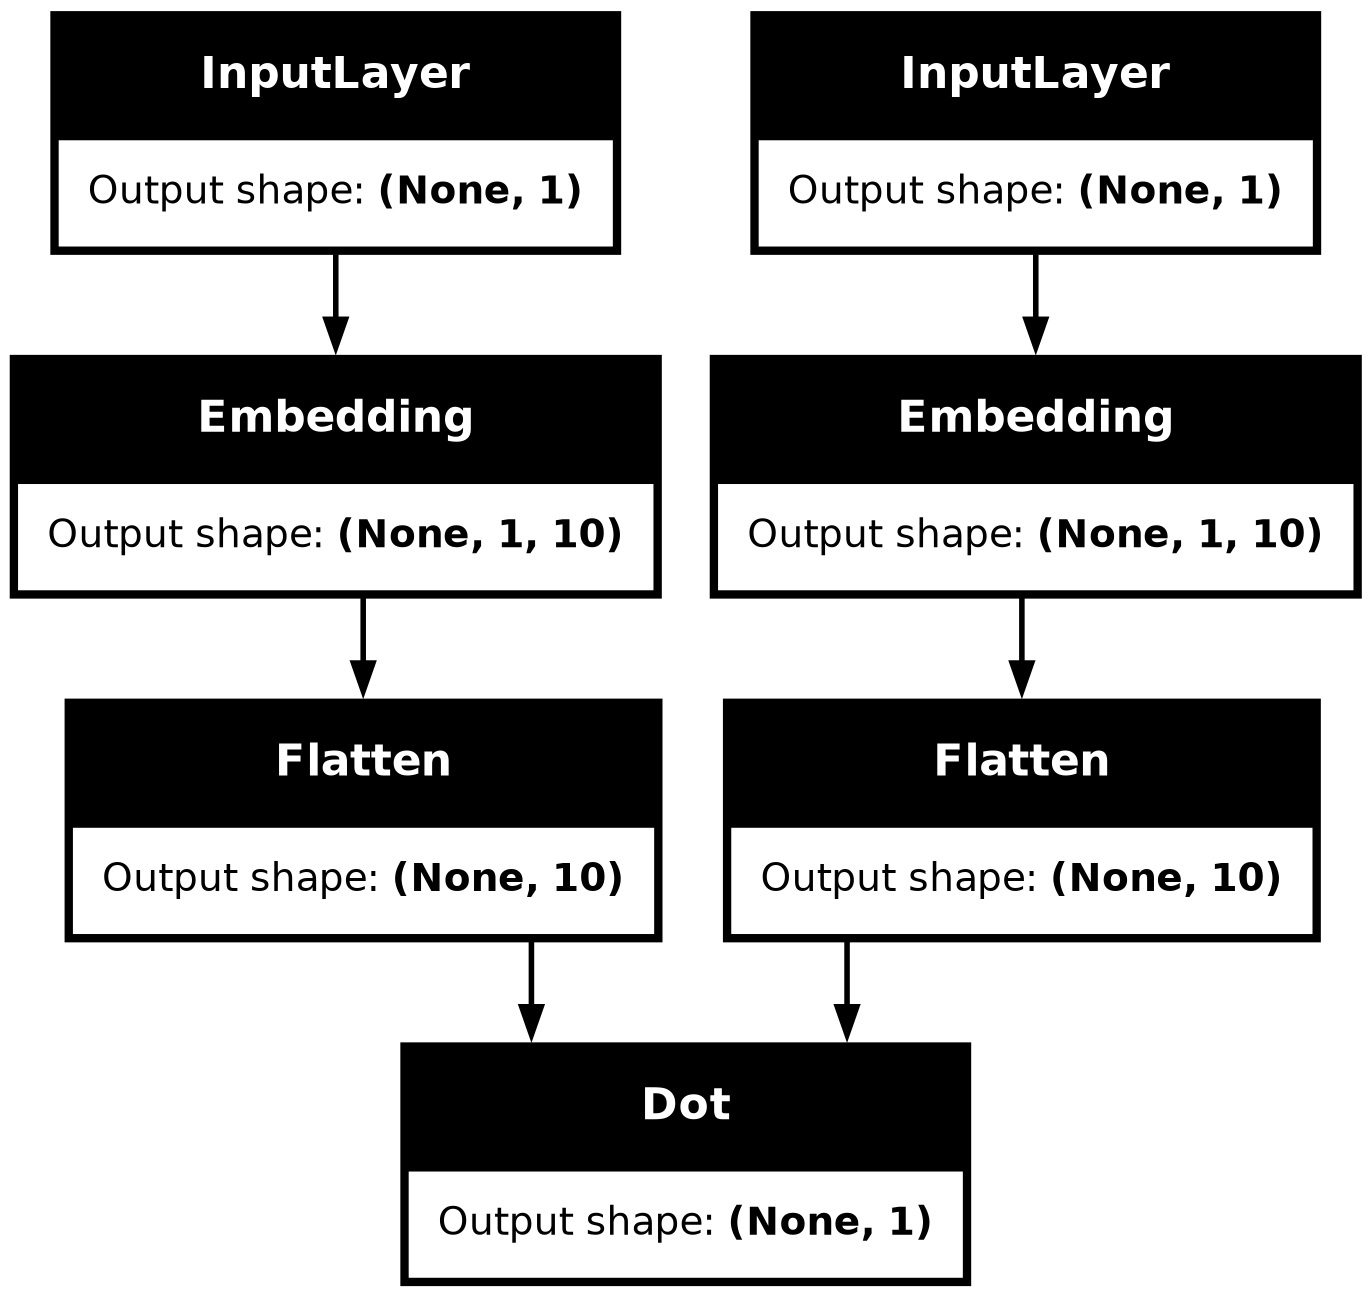

In [8]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, Dot
from keras.utils import plot_model

# Let's use a higher latent dimension.
latent_dim = 10

# Assuming you have defined num_movies and num_users

movie_input = Input(shape=[1], name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)


user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = Dot(axes=1, name='dot-product')([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')

plot_model(model, show_shapes=True, to_file='model.png')


In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie-input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding     │ (None, 1, 10)     │     34,490 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding      │ (None, 1, 10)     │      1,050 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-flatten       │ (None, 10)        │          0 │ movie-embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-flatten        │ (None, 10)        │          0 │ user-embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot-product (Dot)   │ (None, 1)         │          0 │ movie-flatten[0]… │
│                     │                   │            │ user-flatten[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,540 (138.83 KB)

 Trainable params: 35,540 (138.83 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 14.0014
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13.7690
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 12.6288
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 9.4350
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.2131
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.1289
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.0272
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.3788
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.8550
Epoch 10/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 1.4841


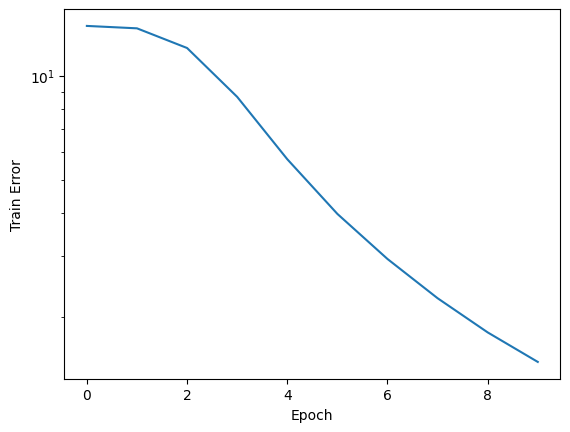

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error: 1.3386374691739944


In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Train the model
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)

# Plot the training error
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Predict on test data
y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_true, y_hat)
print("Mean Absolute Error:", mae)


In [11]:
from keras.constraints import non_neg
from keras.layers import Input, Embedding, Flatten, Dot
from keras.models import Model

latent_dim = 5
num_movies = 1000  # Just an example value
num_users = 500    # Just an example value

movie_input = Input(shape=[1], name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding',
                            embeddings_constraint=non_neg())(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding',
                           embeddings_constraint=non_neg())(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

prod = Dot(axes=1, name='dot-product')([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile('adam', 'mean_squared_error')


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie-input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding     │ (None, 1, 10)     │     10,010 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding      │ (None, 1, 10)     │      5,010 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-flatten       │ (None, 10)        │          0 │ movie-embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-flatten        │ (None, 10)        │          0 │ user-embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot-product (Dot)   │ (None, 1)         │          0 │ movie-flatten[0]… │
│                     │                   │            │ user-flatten[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,020 (58.67 KB)

 Trainable params: 15,020 (58.67 KB)

 Non-trainable params: 0 (0.00 B)

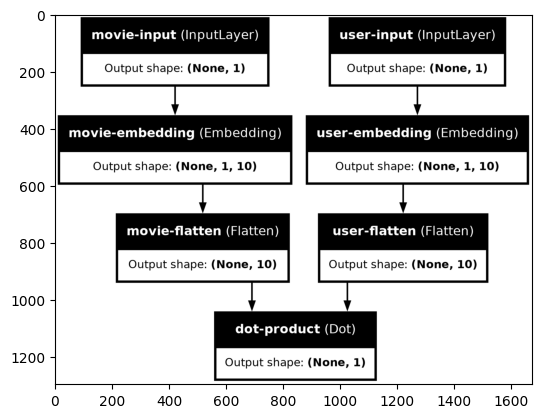

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Embedding, Flatten, Input, Dropout, Dense, concatenate, Dot
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import tensorflow as tf

latent_dim = 10

movie_input = Input(shape=[1], name='movie-input')
movie_embedding = Embedding(num_movies + 1, latent_dim, name='movie-embedding')(movie_input)
movie_vec = Flatten(name='movie-flatten')(movie_embedding)

user_input = Input(shape=[1], name='user-input')
user_embedding = Embedding(num_users + 1, latent_dim, name='user-embedding')(user_input)
user_vec = Flatten(name='user-flatten')(user_embedding)

concat = concatenate([movie_vec, user_vec], name='movie-user-concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_dropout = Dropout(0.2, name='fc-1-dropout')(fc_1)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_dropout = Dropout(0.2, name='fc-2-dropout')(fc_2)
# Instead of using tf.matmul(), use Dot layer for dot product
prod = Dot(axes=1, name='dot-product')([movie_vec, user_vec])

model = Model([user_input, movie_input], prod)
model.compile(optimizer=Adam(learning_rate=0.1), loss='mean_squared_error')

# Plot the model architecture
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

# Optionally, display the model architecture using matplotlib
model.summary()

# Optionally, display the saved image
img = plt.imread('model_plot.png')
plt.imshow(img)
plt.show()


In [13]:
model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie-input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding     │ (None, 1, 10)     │     10,010 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding      │ (None, 1, 10)     │      5,010 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-flatten       │ (None, 10)        │          0 │ movie-embedding[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-flatten        │ (None, 10)        │          0 │ user-embedding[0… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot-product (Dot)   │ (None, 1)         │          0 │ movie-flatten[0]… │
│                     │                   │            │ user-flatten[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 15,020 (58.67 KB)

 Trainable params: 15,020 (58.67 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 6.1699
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.7063
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.2223
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.7079
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 4.4335
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.3564
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 3.3884
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.6288
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 5.4583
Epoch 10/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.5431


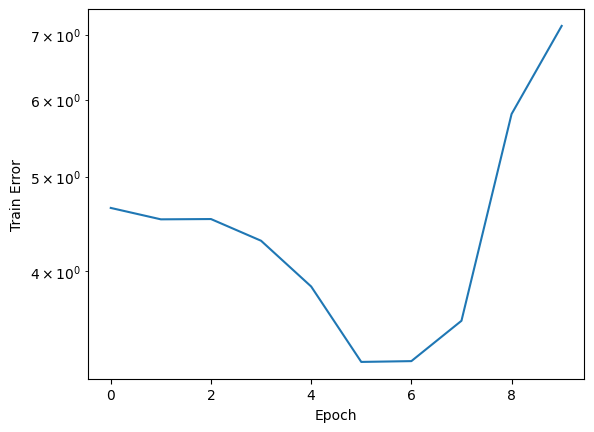

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Absolute Error: 2.0091605887975654


In [14]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Train the model
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)

# Plot the training error
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Predict on test data
y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_true, y_hat)
print("Mean Absolute Error:", mae)


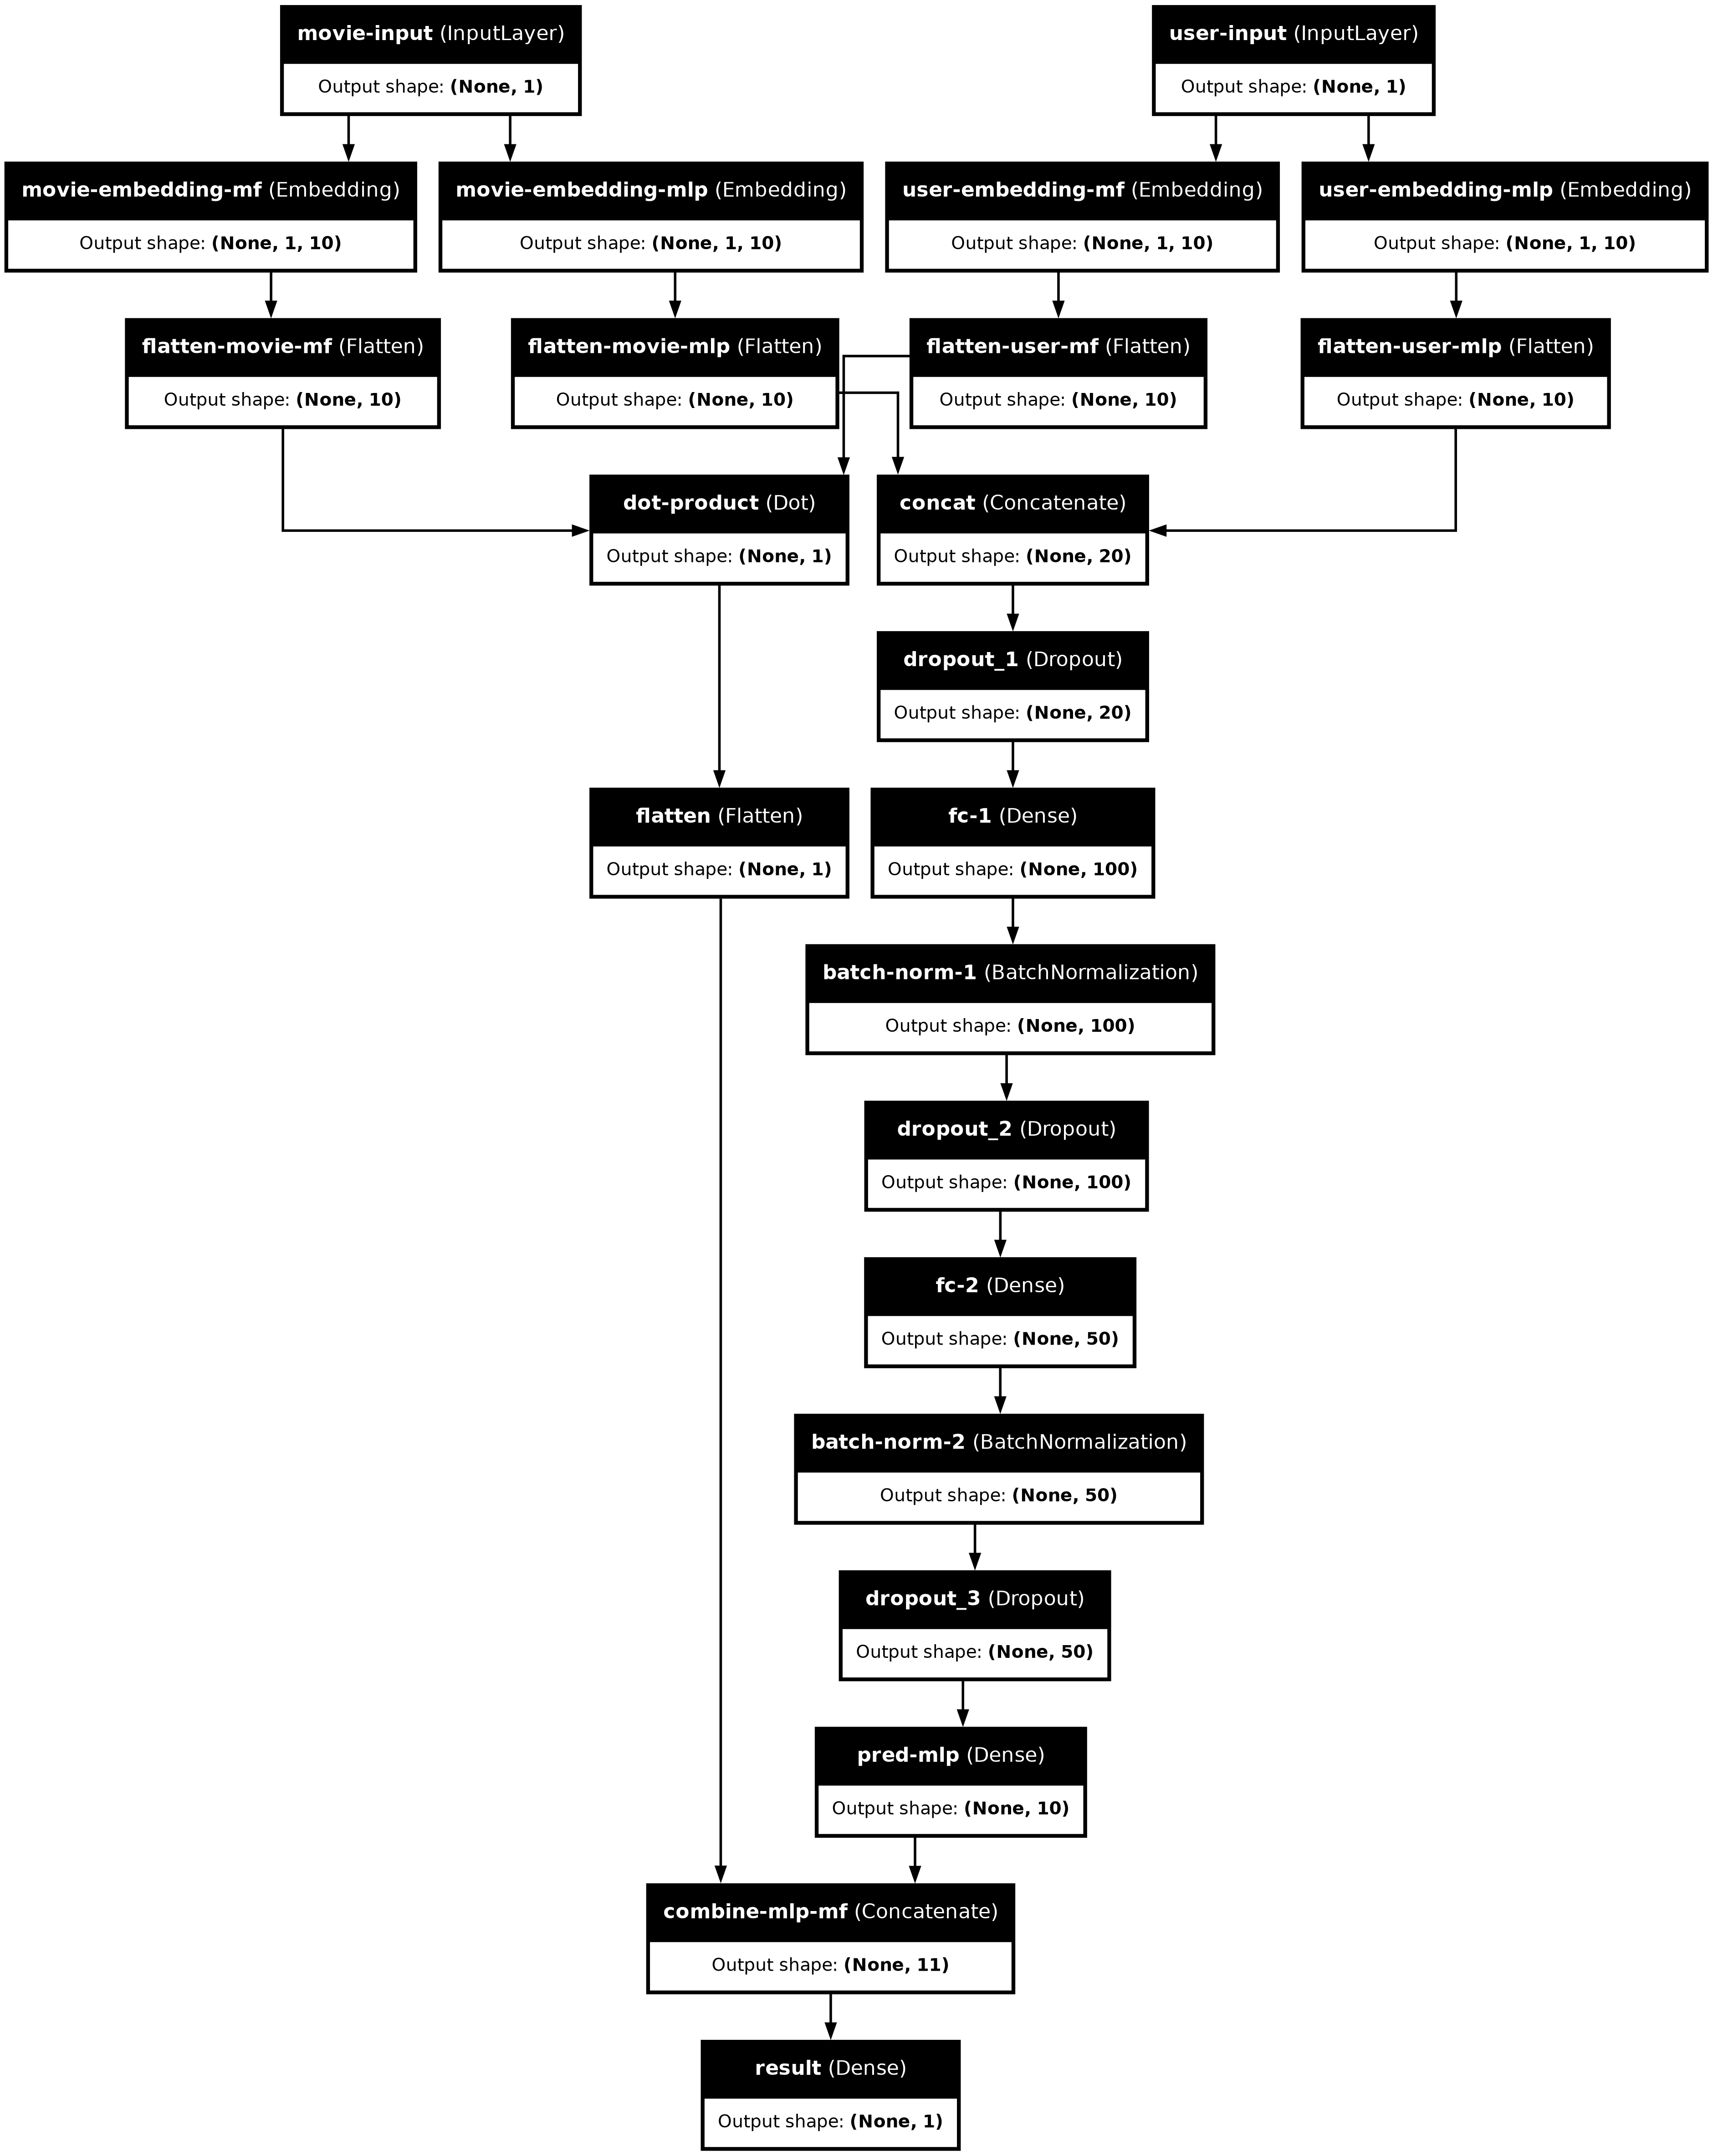

In [15]:
from keras.models import Model
from keras.layers import Embedding, Flatten, Input, concatenate, Dropout, Dense, BatchNormalization, Dot
from keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

latent_dim = 10

# Define inputs
movie_input = Input(shape=[1],name='movie-input')
user_input = Input(shape=[1], name='user-input')

# MLP Embeddings
movie_embedding_mlp = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mlp')(movie_input)
movie_vec_mlp = Flatten(name='flatten-movie-mlp')(movie_embedding_mlp)

user_embedding_mlp = Embedding(num_users + 1, latent_dim, name='user-embedding-mlp')(user_input)
user_vec_mlp = Flatten(name='flatten-user-mlp')(user_embedding_mlp)

# MF Embeddings
movie_embedding_mf = Embedding(num_movies + 1, latent_dim, name='movie-embedding-mf')(movie_input)
movie_vec_mf = Flatten(name='flatten-movie-mf')(movie_embedding_mf)

user_embedding_mf = Embedding(num_users + 1, latent_dim, name='user-embedding-mf')(user_input)
user_vec_mf = Flatten(name='flatten-user-mf')(user_embedding_mf)

# MLP layers
concat = concatenate([movie_vec_mlp, user_vec_mlp], name='concat')
concat_dropout = Dropout(0.2)(concat)
fc_1 = Dense(100, name='fc-1', activation='relu')(concat_dropout)
fc_1_bn = BatchNormalization(name='batch-norm-1')(fc_1)
fc_1_dropout = Dropout(0.2)(fc_1_bn)
fc_2 = Dense(50, name='fc-2', activation='relu')(fc_1_dropout)
fc_2_bn = BatchNormalization(name='batch-norm-2')(fc_2)
fc_2_dropout = Dropout(0.2)(fc_2_bn)

# Prediction from both layers
pred_mlp = Dense(10, name='pred-mlp', activation='relu')(fc_2_dropout)
pred_mf = Dot(axes=1, name='dot-product')([movie_vec_mf, user_vec_mf])
pred_mf = Flatten()(pred_mf)
combine_mlp_mf = concatenate([pred_mf, pred_mlp], name='combine-mlp-mf')

# Final prediction
result = Dense(1, name='result', activation='relu')(combine_mlp_mf)

model = Model([user_input, movie_input], result)
model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_absolute_error')
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


In [16]:
model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ movie-input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding-mlp │ (None, 1, 10)     │     10,010 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding-mlp  │ (None, 1, 10)     │      5,010 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-movie-mlp   │ (None, 10)        │          0 │ movie-embedding-… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-user-mlp    │ (None, 10)        │          0 │ user-embedding-m… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 20)        │          0 │ flatten-movie-ml… │
│ (Concatenate)       │                   │            │ flatten-user-mlp… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 20)        │          0 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc-1 (Dense)        │ (None, 100)       │      2,100 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch-norm-1        │ (None, 100)       │        400 │ fc-1[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 100)       │          0 │ batch-norm-1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie-embedding-mf  │ (None, 1, 10)     │     10,010 │ movie-input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user-embedding-mf   │ (None, 1, 10)     │      5,010 │ user-input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fc-2 (Dense)        │ (None, 50)        │      5,050 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-movie-mf    │ (None, 10)        │          0 │ movie-embedding-… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten-user-mf     │ (None, 10)        │          0 │ user-embedding-m… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch-norm-2        │ (None, 50)        │        200 │ fc-2[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot-product (Dot)   │ (None, 1)         │          0 │ flatten-movie-mf… │
│                     │                   │            │ flatten-user-mf[

 Total params: 38,312 (149.66 KB)

 Trainable params: 38,012 (148.48 KB)

 Non-trainable params: 300 (1.17 KB)

Epoch 1/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 1.1955
Epoch 2/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.7982
Epoch 3/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.6998
Epoch 4/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.6189
Epoch 5/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5787
Epoch 6/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5301
Epoch 7/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5111
Epoch 8/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5058
Epoch 9/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4690
Epoch 10/10
309/309 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4733


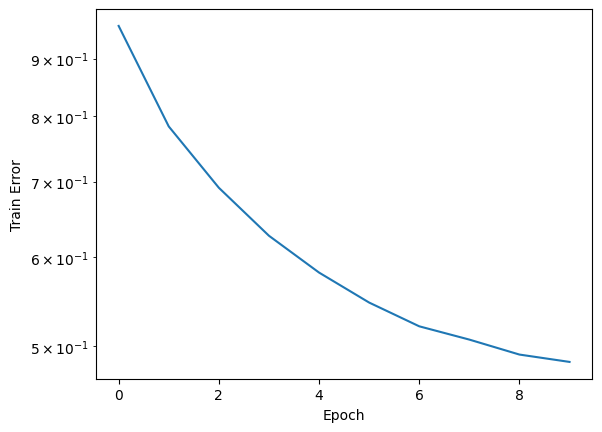

78/78 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Mean Absolute Error: 0.7871370656840316


In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

# Train the model
history = model.fit([train.user_id, train.movie_id], train.rating, epochs=10)

# Plot the training error
plt.plot(history.history['loss'])
plt.yscale('log')
plt.xlabel("Epoch")
plt.ylabel("Train Error")
plt.show()

# Predict on test data
y_hat = np.round(model.predict([test.user_id, test.movie_id]), decimals=2)
y_true = test.rating

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_true, y_hat)
print("Mean Absolute Error:", mae)


In [18]:
# Display top 10 elements of y_hat and y_true side-by-side
for pred, true, movie_id in zip(y_hat[:10], y_true[:10], test.movie_id.values[:10]):
    print(f"Predicted: {pred}, True: {true}, Movie ID: {movie_id}")


Predicted: [2.88], True: 4.0, Movie ID: 238
Predicted: [3.03], True: 3.0, Movie ID: 573
Predicted: [3.78], True: 3.0, Movie ID: 3
Predicted: [3.45], True: 4.0, Movie ID: 1356
Predicted: [3.96], True: 4.0, Movie ID: 1703
Predicted: [2.84], True: 3.0, Movie ID: 301
Predicted: [3.5], True: 4.0, Movie ID: 3161
Predicted: [4.25], True: 5.0, Movie ID: 799
Predicted: [3.01], True: 2.0, Movie ID: 1071
Predicted: [3.45], True: 1.5, Movie ID: 2243
